In [1]:
import numpy as np
import random
seed = 666
random.seed(seed)
np.random.seed(seed)

import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score

from clusterless import data_preprocess
from clusterless import viz_tools
from clusterless import init_gmm
from clusterless import split_merge
from clusterless import smooth_signals
from clusterless import decode_static

load data

In [2]:
rootpath = "data"
sub_id = "dy016"
samp_freq = 30_000

In [3]:
# load unsorted data
spikes_indices, spikes_features, np1_channel_map, stimulus_onset_times, unsorted, trials = \
    data_preprocess.load_unsorted_data(rootpath, sub_id, roi='all', keep_active_trials=False, samp_freq=samp_freq)

In [4]:
# load sorted data
ks_spikes_times, ks_spikes_clusters, ks_spikes_amps, ks_spikes_depths, sorted, ks_trials = \
    data_preprocess.load_kilosort_sorted_data(rootpath, sub_id, keep_active_trials=False, samp_freq=samp_freq)

In [7]:
# load kilosort units that passed ibl's quality metrics
good_ks_spikes_indices = data_preprocess.load_kilosort_good_ibl_units(rootpath, sub_id, roi='all', keep_active_trials = False, samp_freq=30_000)

In [8]:
behave_dict, behave_idx_dict = data_preprocess.load_behaviors_data(rootpath, sub_id)

In [9]:
choices, stimuli, transformed_stimuli, one_hot_stimuli, rewards, priors = data_preprocess.preprocess_static_behaviors(behave_dict)

choices left: 0.769, right: 0.231
stimuli left: 0.507, right: 0.493
reward wrong: 0.231, correct: 0.769


visualize data

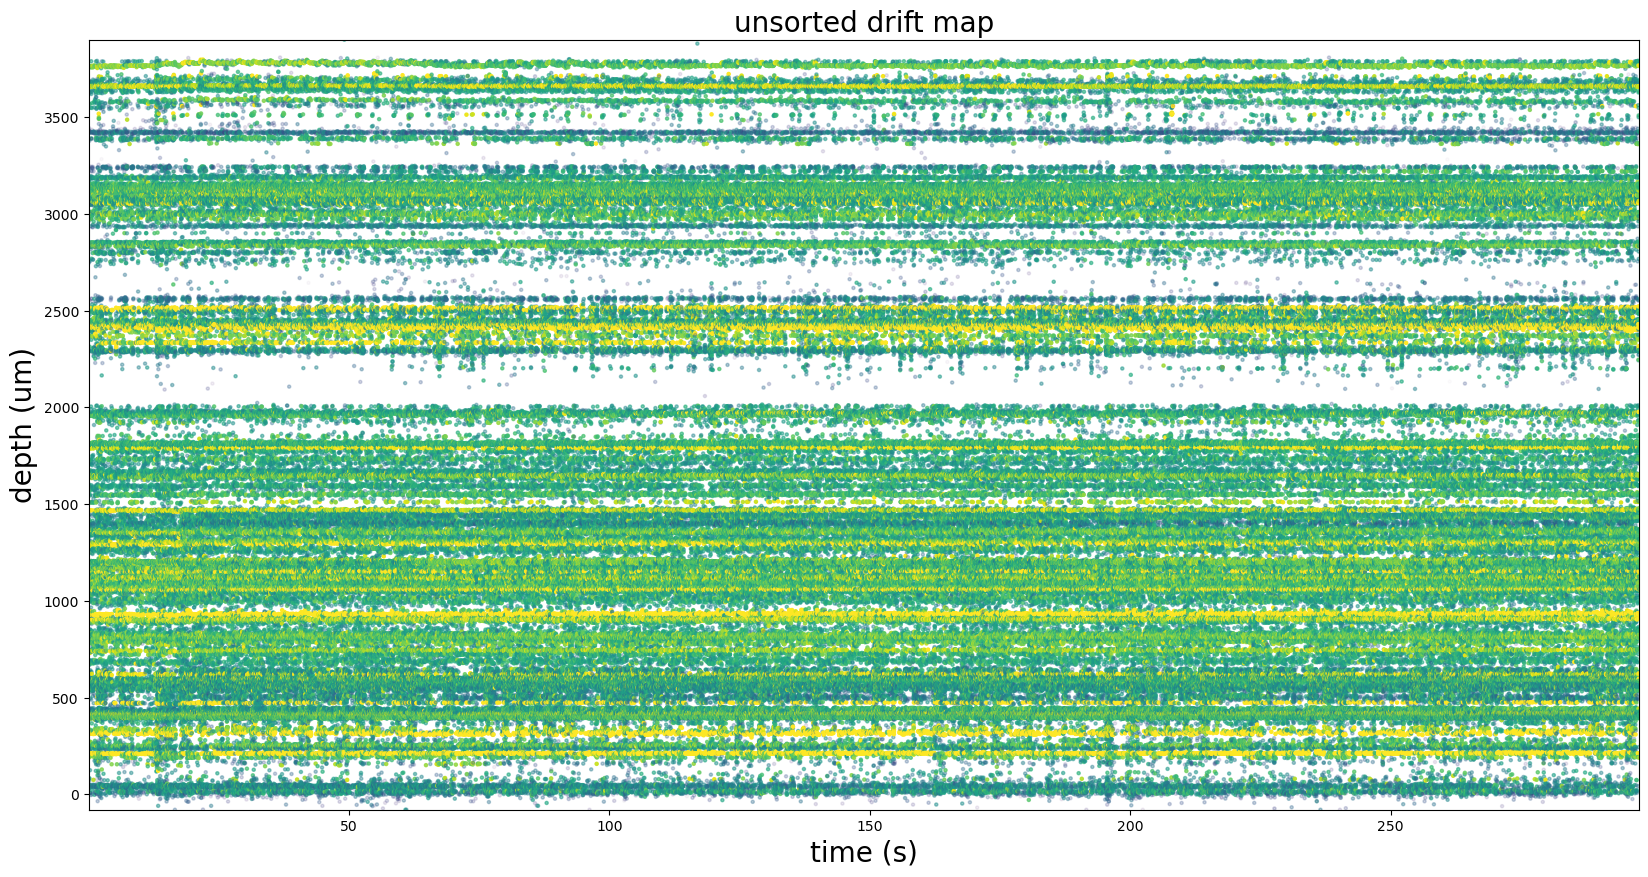

In [6]:
viz_tools.plot_drift_map(spikes_indices, spikes_features, n_spikes_display=500_000, samp_freq=samp_freq)

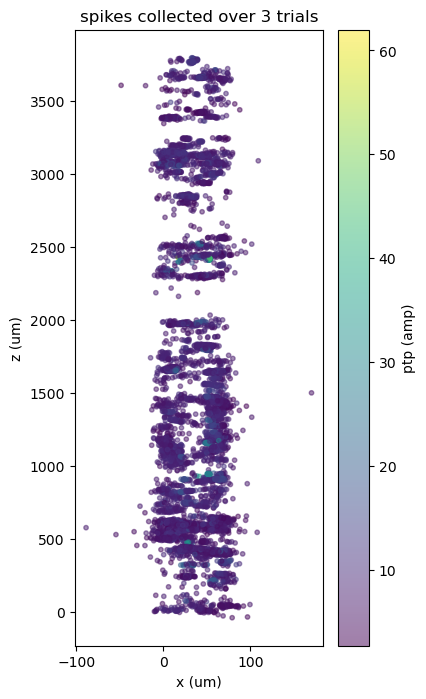

In [4]:
viz_tools.plot_spikes_features(trials, [1, 100, 200])

fit gmm

In [8]:
trials_ids = np.arange(len(trials))
structured_unsorted = np.vstack([trials[i] for i in trials_ids])[:,1:] # follows time order

In [9]:
initial_gmm = init_gmm.initial_gaussian_mixtures('.', sub_id, trials, n_gaussians=300, seed=seed, fit_model=False)

In [10]:
initial_labels = initial_gmm.predict(structured_unsorted)
initial_probs = initial_gmm.predict_proba(structured_unsorted)

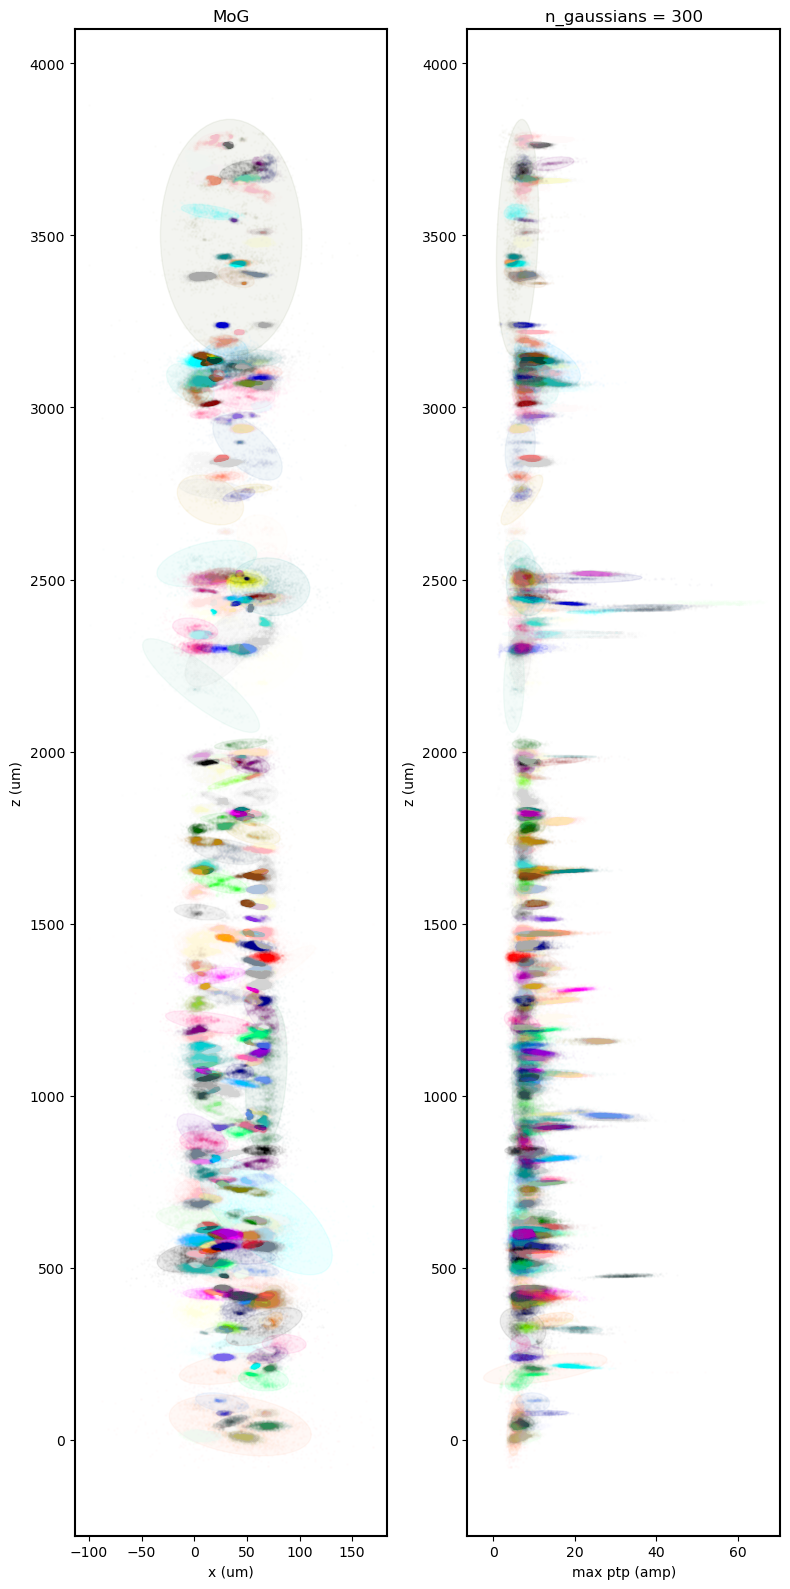

In [17]:
viz_tools.plot_gmm_cluster_viz(structured_unsorted, initial_labels, initial_labels, n_spikes_display=10_000)

split

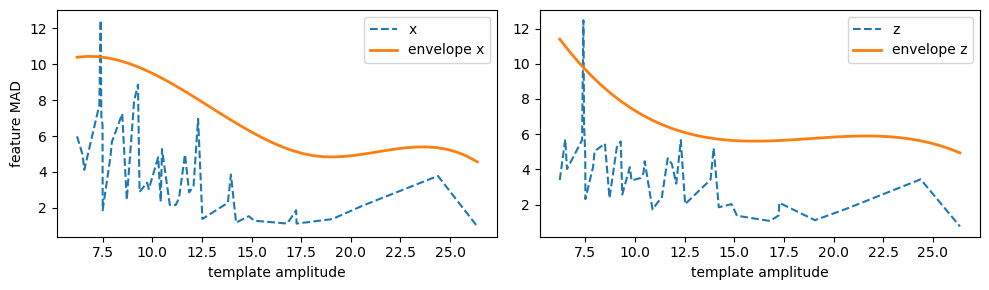

In [11]:
# plot smooth envelope for kilosort template feature MADs

split_ids = split_merge.split_criteria(structured_unsorted, initial_labels, use_ks_template=True)

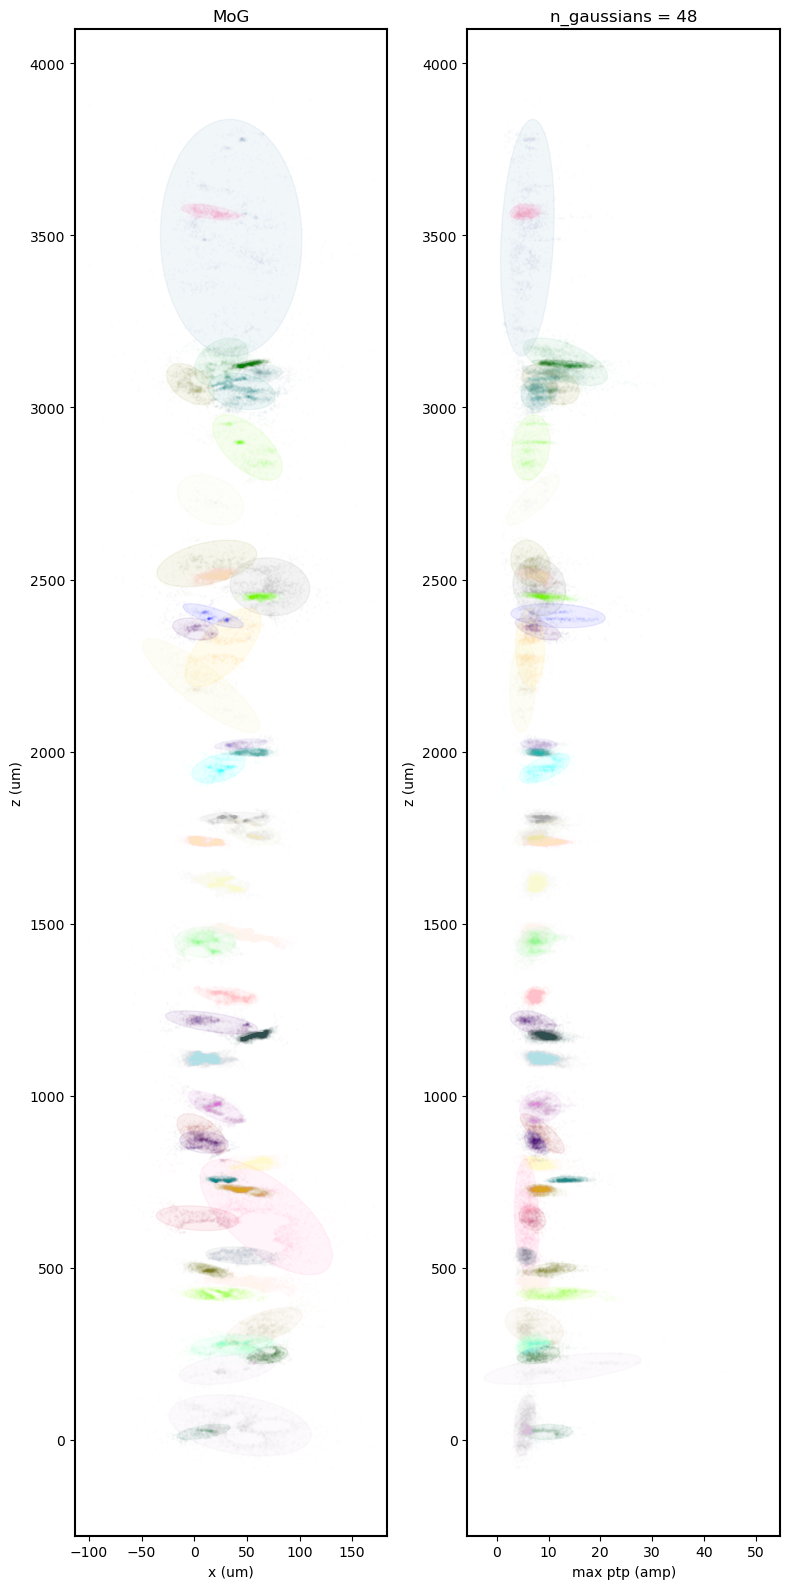

In [19]:
# plot gaussians to be split
viz_tools.plot_gmm_cluster_viz(structured_unsorted, initial_labels, split_ids, n_spikes_display=10_000)

In [10]:
# post_split_gmm = split_merge.split_gaussians('.', sub_id, structured_unsorted, initial_gmm, initial_labels, split_ids, fit_model=True)

initial n_gaussians: 300 bic: 21822855.25
keep 252 gaussians and split 48 gaussians ...
pre-split bic: 22581426.94
split 7th gaussian into 2 gaussians with updated bic: 22520046.99
split 7th gaussian into 3 gaussians with updated bic: 22519856.82
split 7th gaussian into 4 gaussians with updated bic: 22519869.32
split 11th gaussian into 2 gaussians with updated bic: 22450643.09
split 11th gaussian into 3 gaussians with updated bic: 22466099.79
split 12th gaussian into 2 gaussians with updated bic: 22361184.21
split 12th gaussian into 3 gaussians with updated bic: 22369429.86
split 14th gaussian into 2 gaussians with updated bic: 22293679.62
split 14th gaussian into 3 gaussians with updated bic: 22297823.81
split 19th gaussian into 2 gaussians with updated bic: 22221087.74
split 19th gaussian into 3 gaussians with updated bic: 22225913.67
split 69th gaussian into 2 gaussians with updated bic: 22104820.66
split 69th gaussian into 3 gaussians with updated bic: 22107174.62
split 70th gaussi

In [12]:
post_split_gmm = split_merge.split_gaussians('.', sub_id, structured_unsorted, initial_gmm, initial_labels, split_ids, fit_model=False)
post_split_labels = post_split_gmm.predict(structured_unsorted)
post_split_probs = post_split_gmm.predict_proba(structured_unsorted)

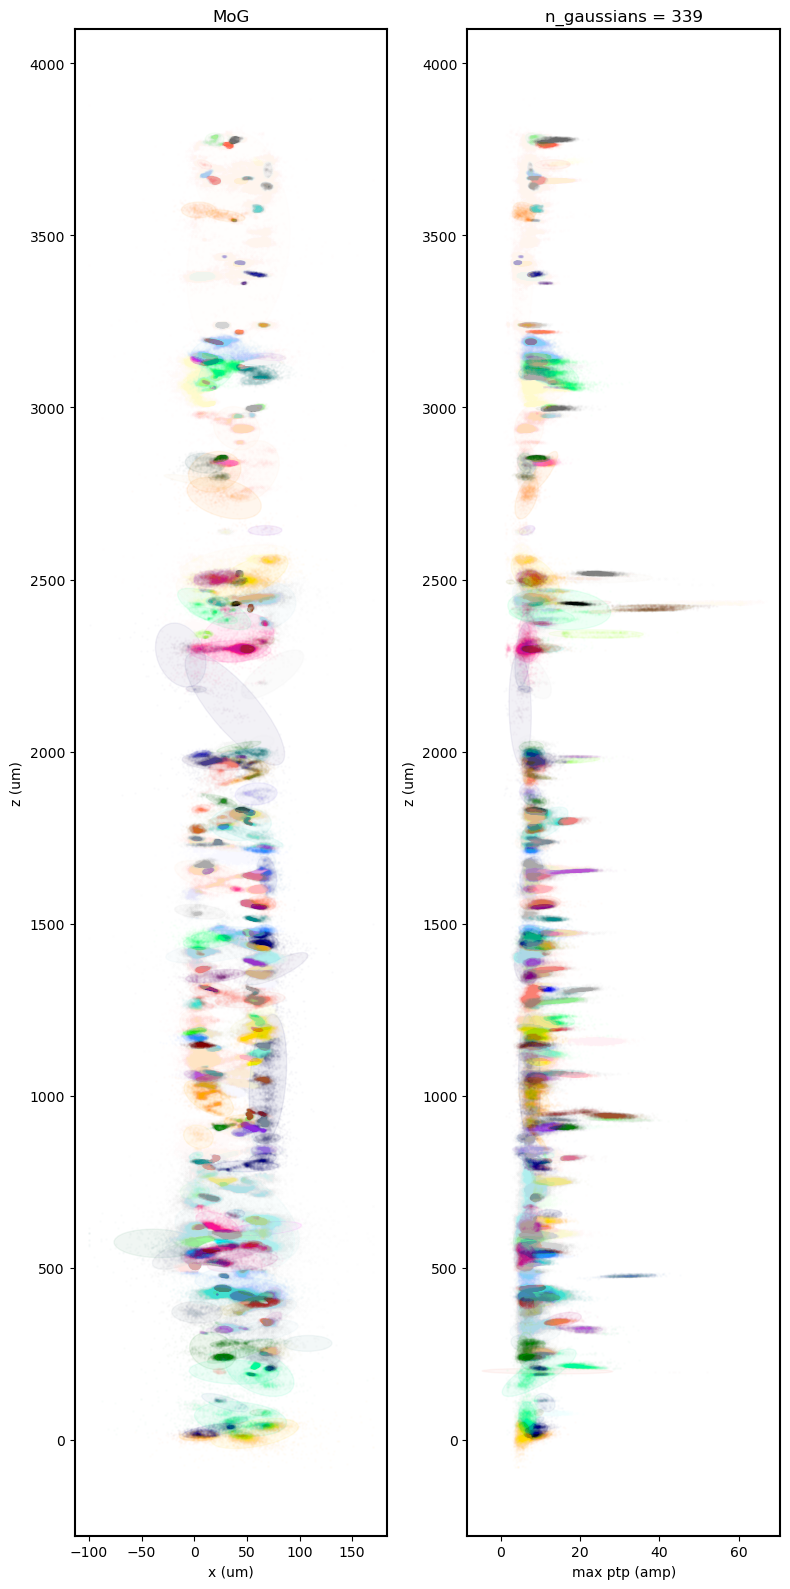

In [21]:
viz_tools.plot_gmm_cluster_viz(structured_unsorted, post_split_labels, post_split_labels, n_spikes_display=30_000)

merge

In [13]:
# corr_mat = split_merge.calc_corr_matrix(post_split_probs)
# np.save(f'pretrained/{sub_id}/corr_mat.npy', corr_mat)
corr_mat = np.load(f'pretrained/{sub_id}/corr_mat.npy')

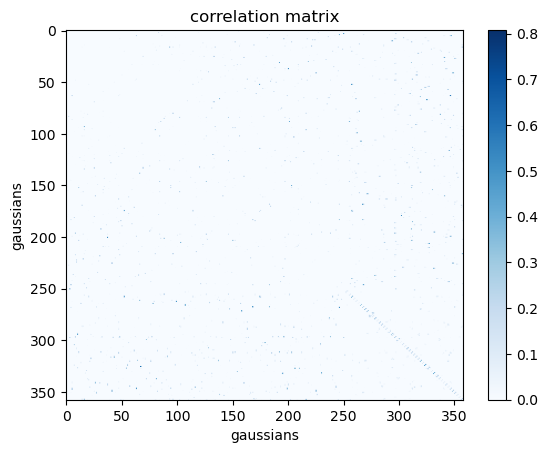

In [26]:
plt.imshow(corr_mat, cmap='Blues', aspect='auto')
plt.xlabel('gaussians')
plt.ylabel('gaussians')
plt.title('correlation matrix')
plt.colorbar();

In [14]:
merge_ids = split_merge.merge_criteria(corr_mat, 0.55)

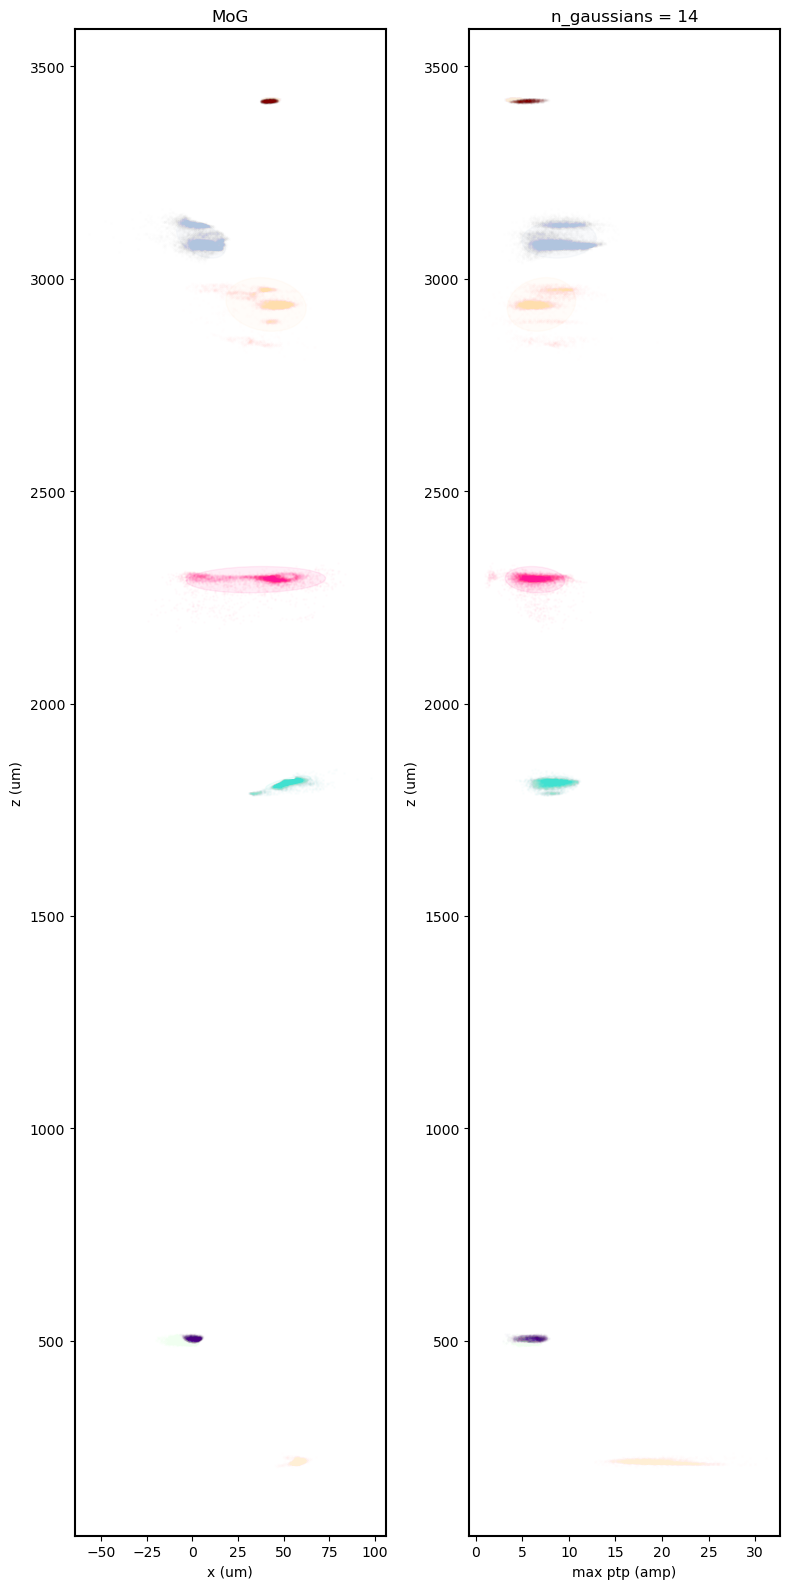

In [24]:
viz_tools.plot_gmm_cluster_viz(structured_unsorted, post_split_labels, np.unique(merge_ids), n_spikes_display=30_000)

In [14]:
# post_merge_gmm = split_merge.merge_gaussians('.', sub_id, structured_unsorted, post_split_gmm, post_split_labels, merge_ids, fit_model=True)

initial n_gaussians: 358 bic: 19413030.92
keep 330 gaussians and merge 14 gaussians ...
pre-merge bic: 19593303.07
merge pairs 3 and 250 with updated bic: 19556332.16
merge pairs 37 and 200 with updated bic: 19495725.33
merge pairs 52 and 257 with updated bic: 19424711.71
merge pairs 63 and 346 with updated bic: 19331591.99
merge pairs 67 and 325 with updated bic: 19284817.36
merge pairs 99 and 262 with updated bic: 19229876.51
merge pairs 168 and 267 with updated bic: 19157211.05
merge pairs 200 and 37 with updated bic: 19148287.91
merge pairs 250 and 3 with updated bic: 19143349.08
merge pairs 257 and 52 with updated bic: 19125673.27
merge pairs 262 and 99 with updated bic: 19115586.15
merge pairs 267 and 168 with updated bic: 19099454.56
merge pairs 325 and 67 with updated bic: 19094795.64
merge pairs 346 and 63 with updated bic: 19068888.04


In [15]:
post_merge_gmm = split_merge.merge_gaussians('.', sub_id, structured_unsorted, post_split_gmm, post_split_labels, merge_ids, fit_model=False)

In [16]:
post_merge_labels = post_merge_gmm.predict(structured_unsorted)
post_merge_probs = post_merge_gmm.predict_proba(structured_unsorted)

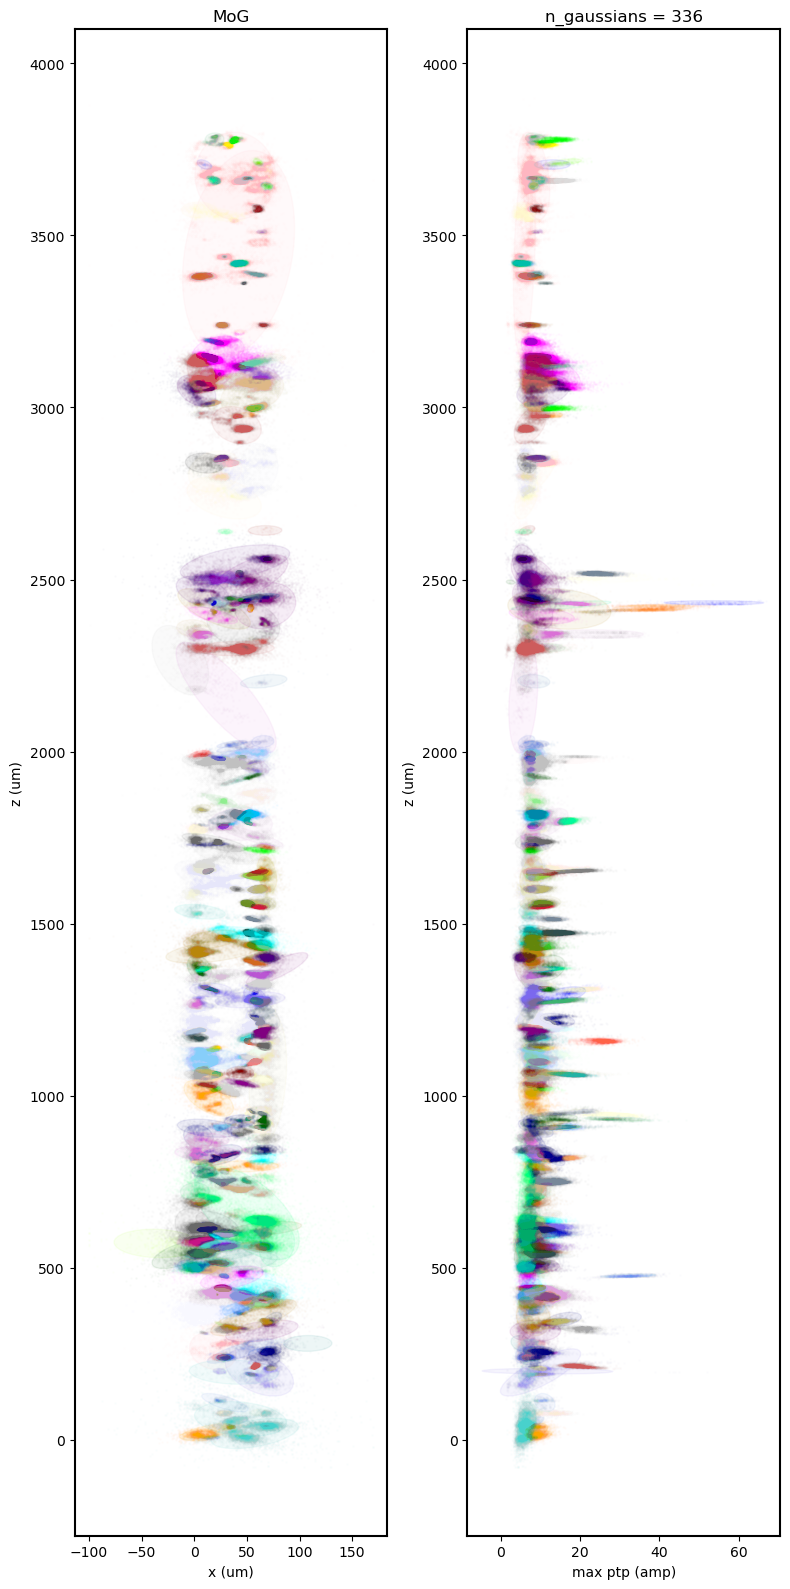

In [27]:
viz_tools.plot_gmm_cluster_viz(structured_unsorted, post_merge_labels, post_merge_labels, n_spikes_display=30_000)

compute neural activity and tpca

In [16]:
sorted_neural_data = data_preprocess.compute_time_binned_neural_activity((ks_spikes_times, ks_spikes_clusters), 'sorted', stimulus_onset_times, regional=False)
sorted_tpca_proj, sorted_tpca_recon = smooth_signals.tpca(sorted_neural_data, n_projs=15)
print(f'sorted neural data shape: {sorted_neural_data.shape}')
print(f'sorted neural projections shape: {sorted_tpca_proj.shape}')
print(f'sorted neural reconstructions shape: {sorted_tpca_recon.shape}')

sorted neural data shape: (286, 514, 30)
sorted neural projections shape: (286, 514, 15)
sorted neural reconstructions shape: (286, 514, 30)


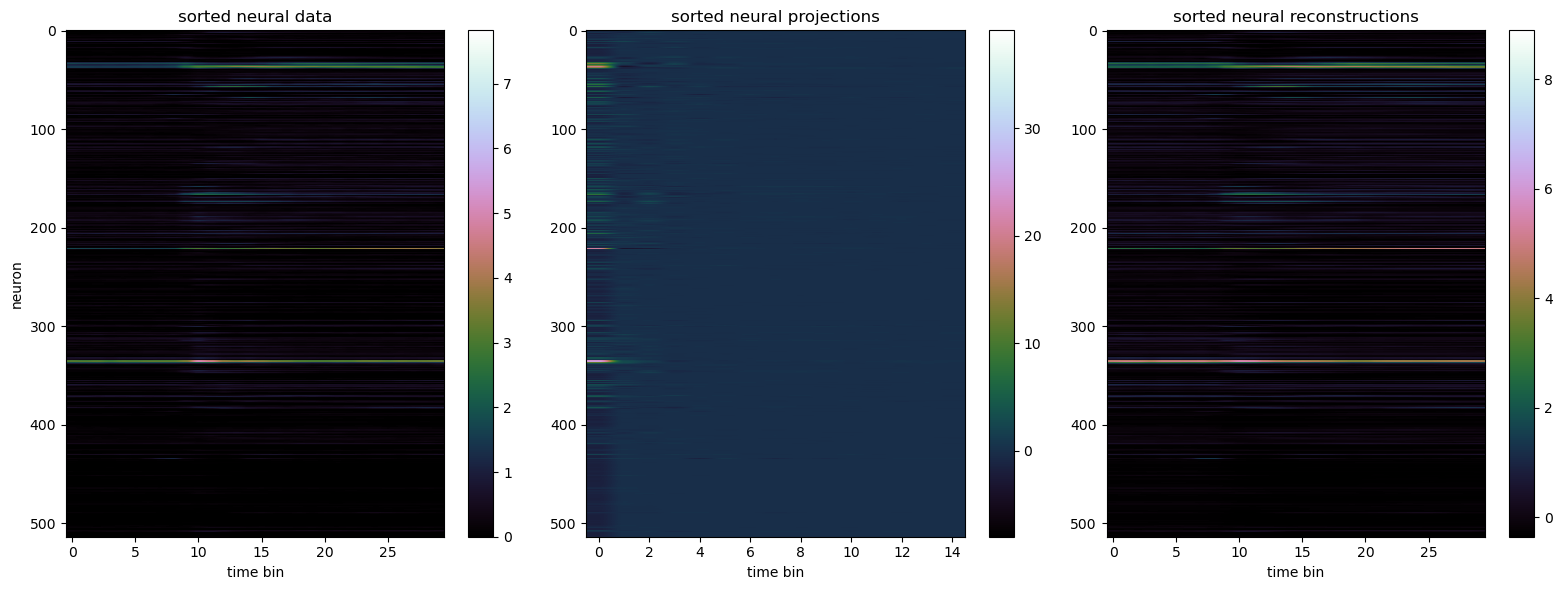

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(16,6))

p1 = axes[0].imshow(sorted_neural_data.mean(0), aspect='auto', cmap='cubehelix')
axes[0].set_title('sorted neural data')
axes[0].set_xlabel('time bin')
axes[0].set_ylabel('neuron')
plt.colorbar(p1, ax=axes[0]);

p2 = axes[1].imshow(sorted_tpca_proj.mean(0), aspect='auto', cmap='cubehelix')
axes[1].set_title('sorted neural projections')
axes[1].set_xlabel('time bin')
plt.colorbar(p2, ax=axes[1]);

p3 = axes[2].imshow(sorted_tpca_recon.mean(0), aspect='auto', cmap='cubehelix')
axes[2].set_title('sorted neural reconstructions')
axes[2].set_xlabel('time bin')
plt.colorbar(p3, ax=axes[2]);

plt.tight_layout()
plt.show()

In [27]:
good_ks_neural_data = data_preprocess.compute_time_binned_neural_activity(good_ks_spikes_indices, 'good units', stimulus_onset_times, regional=False)
good_ks_tpca_proj, good_ks_tpca_recon = smooth_signals.tpca(good_ks_neural_data, n_projs=15)
print(f'good kilosort neural data shape: {good_ks_neural_data.shape}')
print(f'good kilosort neural projections shape: {good_ks_tpca_proj.shape}')
print(f'good kilosort neural reconstructions shape: {good_ks_tpca_recon.shape}')

good kilosort neural data shape: (286, 123, 30)
good kilosort neural projections shape: (286, 123, 15)
good kilosort neural reconstructions shape: (286, 123, 30)


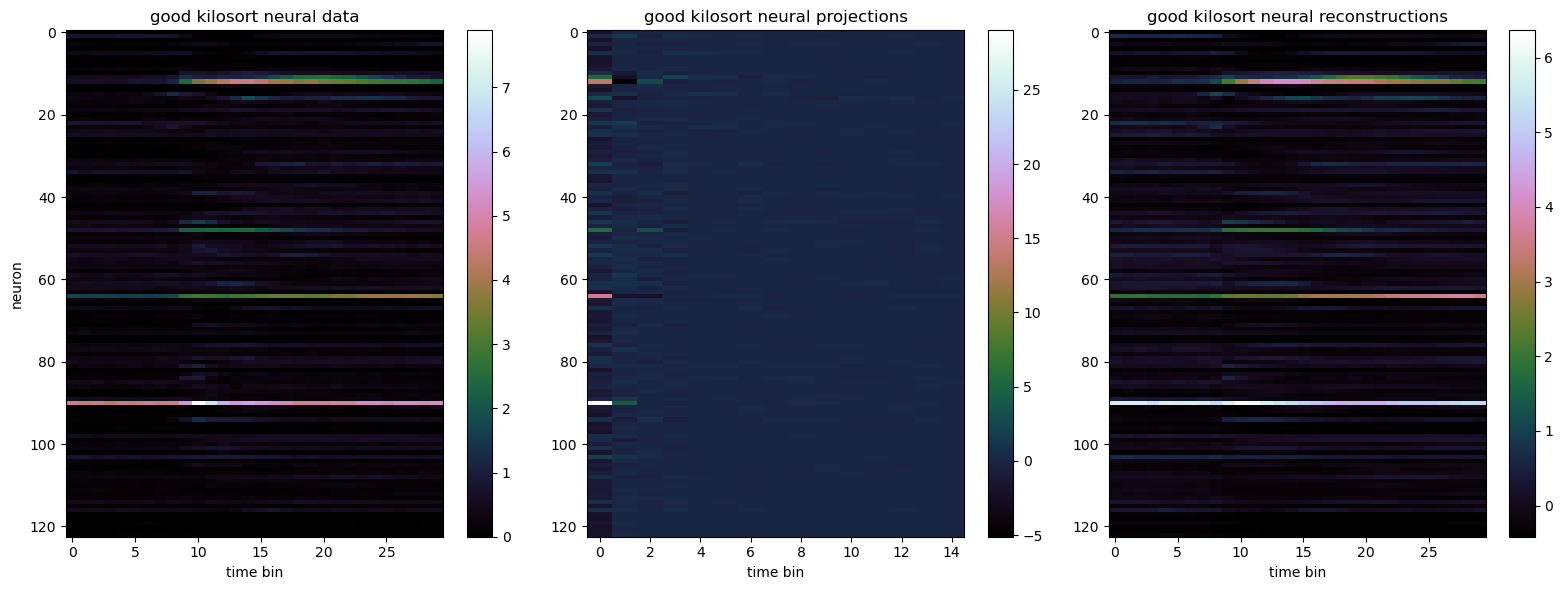

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(16,6))

p1 = axes[0].imshow(good_ks_neural_data.mean(0), aspect='auto', cmap='cubehelix')
axes[0].set_title('good kilosort neural data')
axes[0].set_xlabel('time bin')
axes[0].set_ylabel('neuron')
plt.colorbar(p1, ax=axes[0]);

p2 = axes[1].imshow(good_ks_tpca_proj.mean(0), aspect='auto', cmap='cubehelix')
axes[1].set_title('good kilosort neural projections')
axes[1].set_xlabel('time bin')
plt.colorbar(p2, ax=axes[1]);

p3 = axes[2].imshow(good_ks_tpca_recon.mean(0), aspect='auto', cmap='cubehelix')
axes[2].set_title('good kilosort neural reconstructions')
axes[2].set_xlabel('time bin')
plt.colorbar(p3, ax=axes[2]);

plt.tight_layout()
plt.show()

In [18]:
unsorted_neural_data = data_preprocess.compute_time_binned_neural_activity(spikes_indices, 'unsorted', stimulus_onset_times, regional=False)
unsorted_tpca_proj, unsorted_tpca_recon = smooth_signals.tpca(unsorted_neural_data, n_projs=15)
print(f'unsorted neural data shape: {unsorted_neural_data.shape}')
print(f'unsorted neural projections shape: {unsorted_tpca_proj.shape}')
print(f'unsorted neural reconstructions shape: {unsorted_tpca_recon.shape}')

unsorted neural data shape: (286, 384, 30)
unsorted neural projections shape: (286, 384, 15)
unsorted neural reconstructions shape: (286, 384, 30)


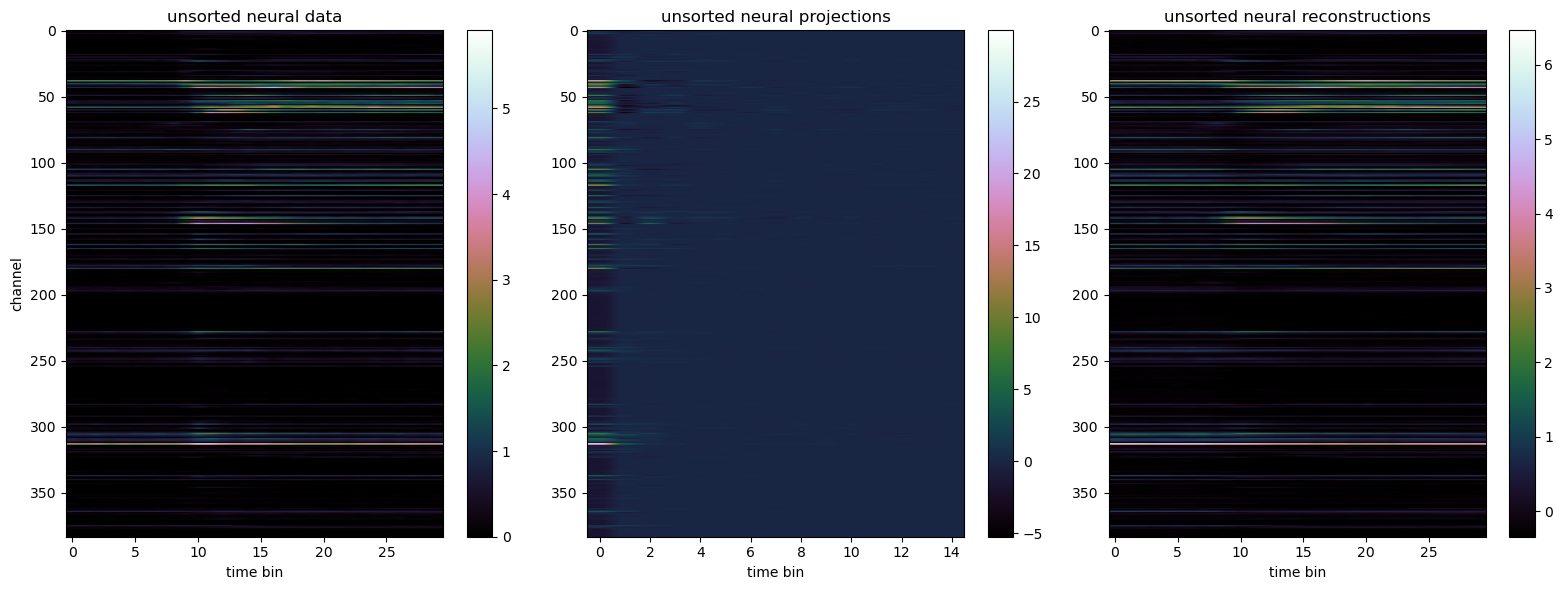

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(16,6))

p1 = axes[0].imshow(unsorted_neural_data.mean(0), aspect='auto', cmap='cubehelix')
axes[0].set_title('unsorted neural data')
axes[0].set_xlabel('time bin')
axes[0].set_ylabel('channel')
plt.colorbar(p1, ax=axes[0]);

p2 = axes[1].imshow(unsorted_tpca_proj.mean(0), aspect='auto', cmap='cubehelix')
axes[1].set_title('unsorted neural projections')
axes[1].set_xlabel('time bin')
plt.colorbar(p2, ax=axes[1]);

p3 = axes[2].imshow(unsorted_tpca_recon.mean(0), aspect='auto', cmap='cubehelix')
axes[2].set_title('unsorted neural reconstructions')
axes[2].set_xlabel('time bin')
plt.colorbar(p3, ax=axes[2]);

plt.tight_layout()
plt.show()

In [21]:
trials_ids = np.arange(len(trials))
spikes_times = np.vstack([trials[i] for i in trials_ids])[:,0]

clusterless_neural_data = data_preprocess.\
    compute_time_binned_neural_activity((spikes_times, post_merge_labels, post_merge_probs), 
                                            'clusterless', stimulus_onset_times, regional=False)
clusterless_tpca_proj, clusterless_tpca_recon = smooth_signals.tpca(clusterless_neural_data, n_projs=15)
print(f'clusterless neural data shape: {clusterless_neural_data.shape}')
print(f'clusterless neural projections shape: {clusterless_tpca_proj.shape}')
print(f'clusterless neural reconstructions shape: {clusterless_tpca_recon.shape}')

clusterless neural data shape: (286, 344, 30)
clusterless neural projections shape: (286, 344, 15)
clusterless neural reconstructions shape: (286, 344, 30)


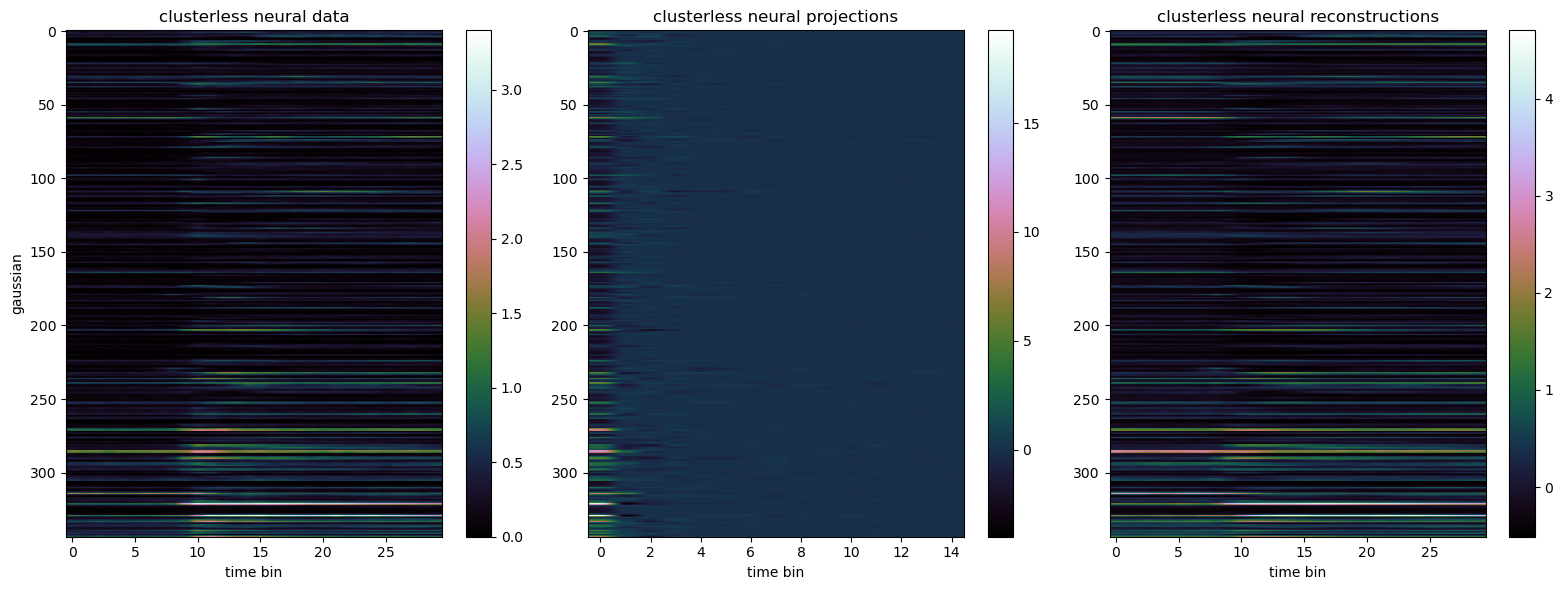

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(16,6))

p1 = axes[0].imshow(clusterless_neural_data.mean(0), aspect='auto', cmap='cubehelix')
axes[0].set_title('clusterless neural data')
axes[0].set_xlabel('time bin')
axes[0].set_ylabel('gaussian')
plt.colorbar(p1, ax=axes[0]);

p2 = axes[1].imshow(clusterless_tpca_proj.mean(0), aspect='auto', cmap='cubehelix')
axes[1].set_title('clusterless neural projections')
axes[1].set_xlabel('time bin')
plt.colorbar(p2, ax=axes[1]);

p3 = axes[2].imshow(clusterless_tpca_recon.mean(0), aspect='auto', cmap='cubehelix')
axes[2].set_title('clusterless neural reconstructions')
axes[2].set_xlabel('time bin')
plt.colorbar(p3, ax=axes[2]);

plt.tight_layout()
plt.show()

decode static behaviors

In [32]:
cv_accs, cv_aucs, cv_ids, cv_obs, cv_preds, cv_probs = decode_static.cv_decode_static(sorted_neural_data, choices, behave_type='choice', n_folds=5, seed=seed, shuffle=True)

choice fold 1 test accuracy: 0.948 auc: 0.993
choice fold 2 test accuracy: 0.877 auc: 0.946
choice fold 3 test accuracy: 0.912 auc: 0.944
choice fold 4 test accuracy: 0.930 auc: 0.978
choice fold 5 test accuracy: 0.912 auc: 0.853
choice mean of 5-fold cv accuracy: 0.916 auc: 0.943
choice sd of 5-fold cv accuracy: 0.024 auc: 0.049


In [31]:
cv_accs, cv_aucs, cv_ids, cv_obs, cv_preds, cv_probs = decode_static.cv_decode_static(good_ks_neural_data, choices, behave_type='choice', n_folds=5, seed=seed, shuffle=True)

choice fold 1 test accuracy: 0.897 auc: 0.966
choice fold 2 test accuracy: 0.860 auc: 0.942
choice fold 3 test accuracy: 0.947 auc: 0.959
choice fold 4 test accuracy: 0.895 auc: 0.978
choice fold 5 test accuracy: 0.930 auc: 0.874
choice mean of 5-fold cv accuracy: 0.906 auc: 0.944
choice sd of 5-fold cv accuracy: 0.030 auc: 0.037


In [33]:
cv_accs, cv_aucs, cv_ids, cv_obs, cv_preds, cv_probs = decode_static.cv_decode_static(unsorted_neural_data, choices, behave_type='choice', n_folds=5, seed=seed, shuffle=True)

choice fold 1 test accuracy: 0.948 auc: 0.978
choice fold 2 test accuracy: 0.860 auc: 0.953
choice fold 3 test accuracy: 0.930 auc: 0.959
choice fold 4 test accuracy: 0.912 auc: 0.984
choice fold 5 test accuracy: 0.895 auc: 0.917
choice mean of 5-fold cv accuracy: 0.909 auc: 0.958
choice sd of 5-fold cv accuracy: 0.030 auc: 0.024


In [34]:
cv_accs, cv_aucs, cv_ids, cv_obs, cv_preds, cv_probs = decode_static.cv_decode_static(clusterless_neural_data, choices, behave_type='choice', n_folds=5, seed=seed, shuffle=True)

choice fold 1 test accuracy: 0.948 auc: 0.973
choice fold 2 test accuracy: 0.842 auc: 0.946
choice fold 3 test accuracy: 0.965 auc: 0.957
choice fold 4 test accuracy: 0.965 auc: 0.990
choice fold 5 test accuracy: 0.912 auc: 0.926
choice mean of 5-fold cv accuracy: 0.926 auc: 0.958
choice sd of 5-fold cv accuracy: 0.046 auc: 0.022


In [35]:
cv_accs, cv_aucs, cv_ids, cv_obs, cv_preds, cv_probs = decode_static.cv_decode_static(sorted_neural_data, one_hot_stimuli, behave_type='stimulus', n_folds=5, seed=seed, shuffle=True)

stimulus fold 1 test accuracy: 0.414 auc: 0.801
stimulus fold 2 test accuracy: 0.368 auc: 0.796
stimulus fold 3 test accuracy: 0.281 auc: 0.763
stimulus fold 4 test accuracy: 0.368 auc: 0.815
stimulus fold 5 test accuracy: 0.368 auc: 0.701
stimulus mean of 5-fold cv accuracy: 0.360 auc: 0.775
stimulus sd of 5-fold cv accuracy: 0.043 auc: 0.041


In [36]:
cv_accs, cv_aucs, cv_ids, cv_obs, cv_preds, cv_probs = decode_static.cv_decode_static(good_ks_neural_data, one_hot_stimuli, behave_type='stimulus', n_folds=5, seed=seed, shuffle=True)

stimulus fold 1 test accuracy: 0.379 auc: 0.850
stimulus fold 2 test accuracy: 0.316 auc: 0.803
stimulus fold 3 test accuracy: 0.333 auc: 0.793
stimulus fold 4 test accuracy: 0.368 auc: 0.825
stimulus fold 5 test accuracy: 0.421 auc: 0.752
stimulus mean of 5-fold cv accuracy: 0.364 auc: 0.804
stimulus sd of 5-fold cv accuracy: 0.037 auc: 0.033


In [37]:
cv_accs, cv_aucs, cv_ids, cv_obs, cv_preds, cv_probs = decode_static.cv_decode_static(unsorted_neural_data, one_hot_stimuli, behave_type='stimulus', n_folds=5, seed=seed, shuffle=True)

stimulus fold 1 test accuracy: 0.328 auc: 0.804
stimulus fold 2 test accuracy: 0.333 auc: 0.782
stimulus fold 3 test accuracy: 0.228 auc: 0.772
stimulus fold 4 test accuracy: 0.351 auc: 0.788
stimulus fold 5 test accuracy: 0.316 auc: 0.713
stimulus mean of 5-fold cv accuracy: 0.311 auc: 0.772
stimulus sd of 5-fold cv accuracy: 0.043 auc: 0.031


In [38]:
cv_accs, cv_aucs, cv_ids, cv_obs, cv_preds, cv_probs = decode_static.cv_decode_static(clusterless_neural_data, one_hot_stimuli, behave_type='stimulus', n_folds=5, seed=seed, shuffle=True)

stimulus fold 1 test accuracy: 0.362 auc: 0.818
stimulus fold 2 test accuracy: 0.333 auc: 0.772
stimulus fold 3 test accuracy: 0.263 auc: 0.762
stimulus fold 4 test accuracy: 0.333 auc: 0.809
stimulus fold 5 test accuracy: 0.333 auc: 0.709
stimulus mean of 5-fold cv accuracy: 0.325 auc: 0.774
stimulus sd of 5-fold cv accuracy: 0.033 auc: 0.039


regional decoding

In [31]:
roi = 'PO'
regional_trials = data_preprocess.load_unsorted_data(rootpath, sub_id, roi=roi, keep_active_trials=False, samp_freq=30_000)

regional_clusterless = np.vstack([regional_trials[i] for i in range(len(regional_trials))])[:,2:]
print(f'{regional_clusterless.shape[0]} spikes in roi ' + roi)

regional_labels = post_merge_gmm.predict(regional_clusterless)
regional_probs = post_merge_gmm.predict_proba(regional_clusterless)

regional_spikes_times = np.vstack([regional_trials[i] for i in range(len(regional_trials))])[:,0]

regional_clusterless_neural_data = data_preprocess.\
    compute_time_binned_neural_activity((regional_spikes_times, regional_labels, regional_probs), 
                                            'clusterless', stimulus_onset_times, regional=True)
regional_clusterless_tpca_proj, regional_clusterless_tpca_recon = smooth_signals.tpca(regional_clusterless_neural_data, n_projs=15)
print(f'{roi} clusterless neural data shape: {regional_clusterless_neural_data.shape}')
print(f'{roi} clusterless neural projections shape: {regional_clusterless_tpca_proj.shape}')
print(f'{roi} clusterless neural reconstructions shape: {regional_clusterless_tpca_recon.shape}')

found 58 channels in roi PO
308932 spikes in roi PO
PO clusterless neural data shape: (286, 126, 30)
PO clusterless neural projections shape: (286, 126, 15)
PO clusterless neural reconstructions shape: (286, 126, 30)


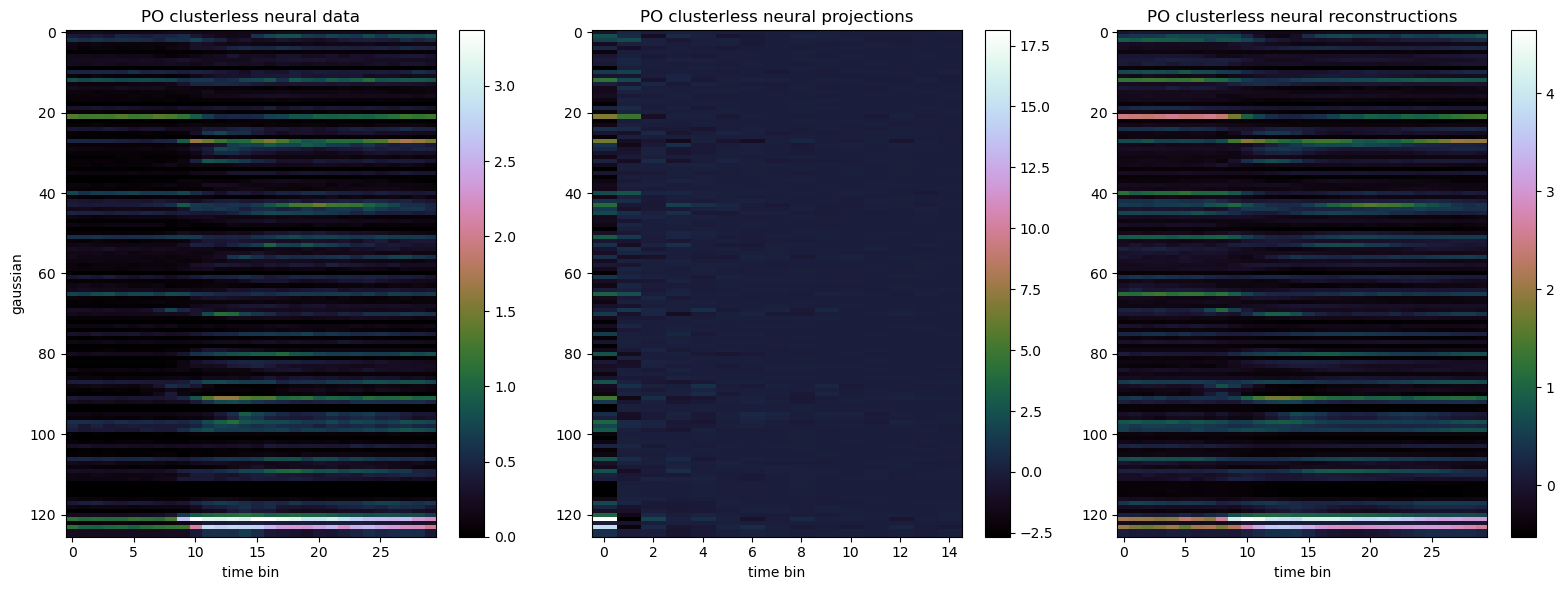

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(16,6))

p1 = axes[0].imshow(regional_clusterless_neural_data.mean(0), aspect='auto', cmap='cubehelix')
axes[0].set_title(roi + ' clusterless neural data')
axes[0].set_xlabel('time bin')
axes[0].set_ylabel('gaussian')
plt.colorbar(p1, ax=axes[0]);

p2 = axes[1].imshow(regional_clusterless_tpca_proj.mean(0), aspect='auto', cmap='cubehelix')
axes[1].set_title(roi + ' clusterless neural projections')
axes[1].set_xlabel('time bin')
plt.colorbar(p2, ax=axes[1]);

p3 = axes[2].imshow(regional_clusterless_tpca_recon.mean(0), aspect='auto', cmap='cubehelix')
axes[2].set_title(roi + ' clusterless neural reconstructions')
axes[2].set_xlabel('time bin')
plt.colorbar(p3, ax=axes[2]);

plt.tight_layout()
plt.show()

In [32]:
cv_accs, cv_aucs, cv_ids, cv_obs, cv_preds, cv_probs = decode_static.cv_decode_static(regional_clusterless_neural_data, choices, behave_type='choice', n_folds=5, seed=seed, shuffle=True)

choice fold 1 test accuracy: 0.879 auc: 0.909
choice fold 2 test accuracy: 0.807 auc: 0.876
choice fold 3 test accuracy: 0.912 auc: 0.923
choice fold 4 test accuracy: 0.842 auc: 0.919
choice fold 5 test accuracy: 0.860 auc: 0.887
choice mean of 5-fold cv accuracy: 0.860 auc: 0.903
choice sd of 5-fold cv accuracy: 0.035 auc: 0.019


In [33]:
cv_accs, cv_aucs, cv_ids, cv_obs, cv_preds, cv_probs = decode_static.cv_decode_static(regional_clusterless_neural_data, one_hot_stimuli, behave_type='stimulus', n_folds=5, seed=seed, shuffle=True)

stimulus fold 1 test accuracy: 0.276 auc: 0.756
stimulus fold 2 test accuracy: 0.333 auc: 0.713
stimulus fold 3 test accuracy: 0.193 auc: 0.724
stimulus fold 4 test accuracy: 0.298 auc: 0.765
stimulus fold 5 test accuracy: 0.281 auc: 0.668
stimulus mean of 5-fold cv accuracy: 0.276 auc: 0.725
stimulus sd of 5-fold cv accuracy: 0.046 auc: 0.034


In [4]:
roi = 'PO'
regional_trials = data_preprocess.load_unsorted_data(rootpath, sub_id, roi=roi, keep_active_trials=False, samp_freq=30_000)
regional_unsorted = np.vstack([regional_trials[i] for i in range(len(regional_trials))])[:,:2]

regional_unsorted_neural_data = data_preprocess.compute_time_binned_neural_activity(regional_unsorted, 'unsorted', stimulus_onset_times, regional=True)
regional_unsorted_tpca_proj, regional_unsorted_tpca_recon = smooth_signals.tpca(regional_unsorted_neural_data, n_projs=15)
print(f'{roi} unsorted neural data shape: {regional_unsorted_neural_data.shape}')
print(f'{roi} unsorted neural projections shape: {regional_unsorted_tpca_proj.shape}')
print(f'{roi} unsorted neural reconstructions shape: {regional_unsorted_tpca_recon.shape}')

found 58 channels in roi PO
PO unsorted neural data shape: (286, 58, 30)
PO unsorted neural projections shape: (286, 58, 15)
PO unsorted neural reconstructions shape: (286, 58, 30)


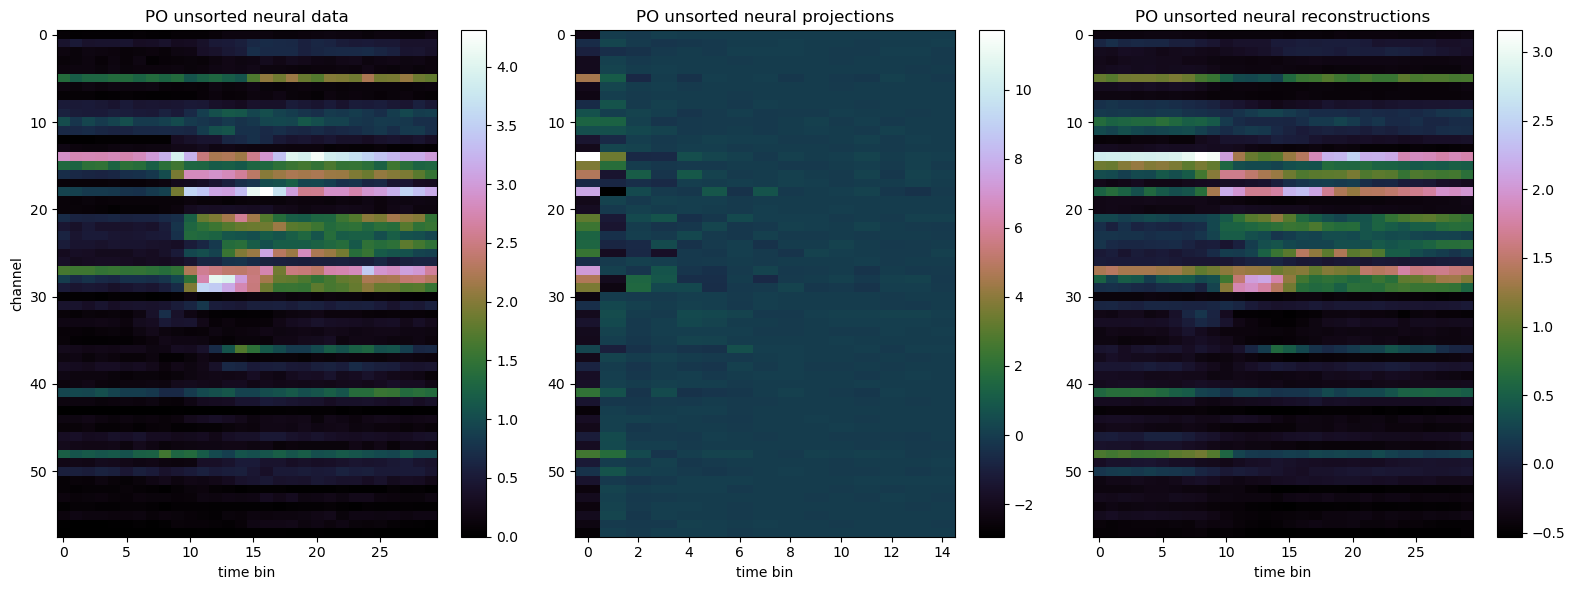

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(16,6))

p1 = axes[0].imshow(regional_unsorted_neural_data.mean(0), aspect='auto', cmap='cubehelix')
axes[0].set_title(roi + ' unsorted neural data')
axes[0].set_xlabel('time bin')
axes[0].set_ylabel('channel')
plt.colorbar(p1, ax=axes[0]);

p2 = axes[1].imshow(regional_unsorted_tpca_proj.mean(0), aspect='auto', cmap='cubehelix')
axes[1].set_title(roi + ' unsorted neural projections')
axes[1].set_xlabel('time bin')
plt.colorbar(p2, ax=axes[1]);

p3 = axes[2].imshow(regional_unsorted_tpca_recon.mean(0), aspect='auto', cmap='cubehelix')
axes[2].set_title(roi + ' unsorted neural reconstructions')
axes[2].set_xlabel('time bin')
plt.colorbar(p3, ax=axes[2]);

plt.tight_layout()
plt.show()

In [9]:
cv_accs, cv_aucs, cv_ids, cv_obs, cv_preds, cv_probs = decode_static.cv_decode_static(regional_unsorted_neural_data, choices, behave_type='choice', n_folds=5, seed=seed, shuffle=True)

choice fold 1 test accuracy: 0.879 auc: 0.932
choice fold 2 test accuracy: 0.789 auc: 0.893
choice fold 3 test accuracy: 0.947 auc: 0.806
choice fold 4 test accuracy: 0.825 auc: 0.900
choice fold 5 test accuracy: 0.825 auc: 0.847
choice mean of 5-fold cv accuracy: 0.853 auc: 0.876
choice sd of 5-fold cv accuracy: 0.055 auc: 0.044


In [10]:
cv_accs, cv_aucs, cv_ids, cv_obs, cv_preds, cv_probs = decode_static.cv_decode_static(regional_unsorted_neural_data, one_hot_stimuli, behave_type='stimulus', n_folds=5, seed=seed, shuffle=True)

stimulus fold 1 test accuracy: 0.293 auc: 0.754
stimulus fold 2 test accuracy: 0.298 auc: 0.734
stimulus fold 3 test accuracy: 0.211 auc: 0.734
stimulus fold 4 test accuracy: 0.316 auc: 0.781
stimulus fold 5 test accuracy: 0.281 auc: 0.705
stimulus mean of 5-fold cv accuracy: 0.280 auc: 0.742
stimulus sd of 5-fold cv accuracy: 0.036 auc: 0.025


In [8]:
roi = 'PO'
regional_sorted = data_preprocess.load_kilosort_sorted_data(rootpath, sub_id, roi=roi, keep_active_trials = False, samp_freq=30_000)
regional_sorted_neural_data = data_preprocess.compute_time_binned_neural_activity(regional_sorted, 'sorted', stimulus_onset_times, regional=True)
regional_sorted_tpca_proj, regional_sorted_tpca_recon = smooth_signals.tpca(regional_sorted_neural_data, n_projs=15)
print(f'{roi} sorted neural data shape: {regional_sorted_neural_data.shape}')
print(f'{roi} sorted neural projections shape: {regional_sorted_tpca_proj.shape}')
print(f'{roi} sorted neural reconstructions shape: {regional_sorted_tpca_recon.shape}')

PO sorted neural data shape: (286, 139, 30)
PO sorted neural projections shape: (286, 139, 15)
PO sorted neural reconstructions shape: (286, 139, 30)


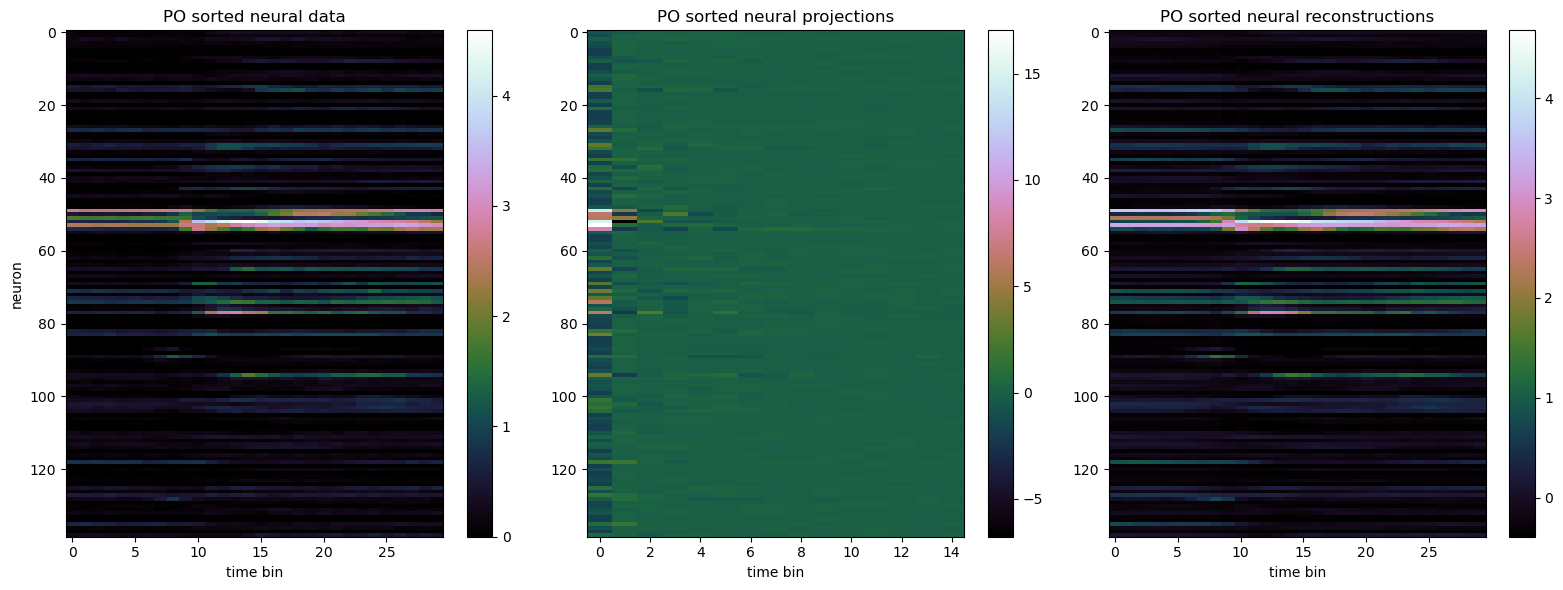

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(16,6))

p1 = axes[0].imshow(regional_sorted_neural_data.mean(0), aspect='auto', cmap='cubehelix')
axes[0].set_title(roi + ' sorted neural data')
axes[0].set_xlabel('time bin')
axes[0].set_ylabel('neuron')
plt.colorbar(p1, ax=axes[0]);

p2 = axes[1].imshow(regional_sorted_tpca_proj.mean(0), aspect='auto', cmap='cubehelix')
axes[1].set_title(roi + ' sorted neural projections')
axes[1].set_xlabel('time bin')
plt.colorbar(p2, ax=axes[1]);

p3 = axes[2].imshow(regional_sorted_tpca_recon.mean(0), aspect='auto', cmap='cubehelix')
axes[2].set_title(roi + ' sorted neural reconstructions')
axes[2].set_xlabel('time bin')
plt.colorbar(p3, ax=axes[2]);

plt.tight_layout()
plt.show()

In [10]:
cv_accs, cv_aucs, cv_ids, cv_obs, cv_preds, cv_probs = decode_static.cv_decode_static(regional_sorted_neural_data, choices, behave_type='choice', n_folds=5, seed=seed, shuffle=True)

choice fold 1 test accuracy: 0.879 auc: 0.945
choice fold 2 test accuracy: 0.807 auc: 0.878
choice fold 3 test accuracy: 0.895 auc: 0.883
choice fold 4 test accuracy: 0.860 auc: 0.917
choice fold 5 test accuracy: 0.842 auc: 0.830
choice mean of 5-fold cv accuracy: 0.857 auc: 0.891
choice sd of 5-fold cv accuracy: 0.030 auc: 0.039


In [11]:
cv_accs, cv_aucs, cv_ids, cv_obs, cv_preds, cv_probs = decode_static.cv_decode_static(regional_sorted_neural_data, one_hot_stimuli, behave_type='stimulus', n_folds=5, seed=seed, shuffle=True)

stimulus fold 1 test accuracy: 0.293 auc: 0.765
stimulus fold 2 test accuracy: 0.316 auc: 0.712
stimulus fold 3 test accuracy: 0.193 auc: 0.717
stimulus fold 4 test accuracy: 0.228 auc: 0.753
stimulus fold 5 test accuracy: 0.281 auc: 0.646
stimulus mean of 5-fold cv accuracy: 0.262 auc: 0.719
stimulus sd of 5-fold cv accuracy: 0.045 auc: 0.042


In [12]:
roi = 'PO'
regional_good_spikes_indices = data_preprocess.load_kilosort_good_ibl_units(rootpath, sub_id, roi=roi, keep_active_trials = False, samp_freq=30_000)
regional_good_neural_data = data_preprocess.compute_time_binned_neural_activity(regional_good_spikes_indices, 'good units', stimulus_onset_times, regional=True)
regional_good_tpca_proj, regional_good_tpca_recon = smooth_signals.tpca(regional_good_neural_data, n_projs=15)
print(f'{roi} good kilosort neural data shape: {regional_good_neural_data.shape}')
print(f'{roi} good kilosort neural projections shape: {regional_good_tpca_proj.shape}')
print(f'{roi} good kilosort neural reconstructions shape: {regional_good_tpca_recon.shape}')

PO good kilosort neural data shape: (286, 32, 30)
PO good kilosort neural projections shape: (286, 32, 15)
PO good kilosort neural reconstructions shape: (286, 32, 30)


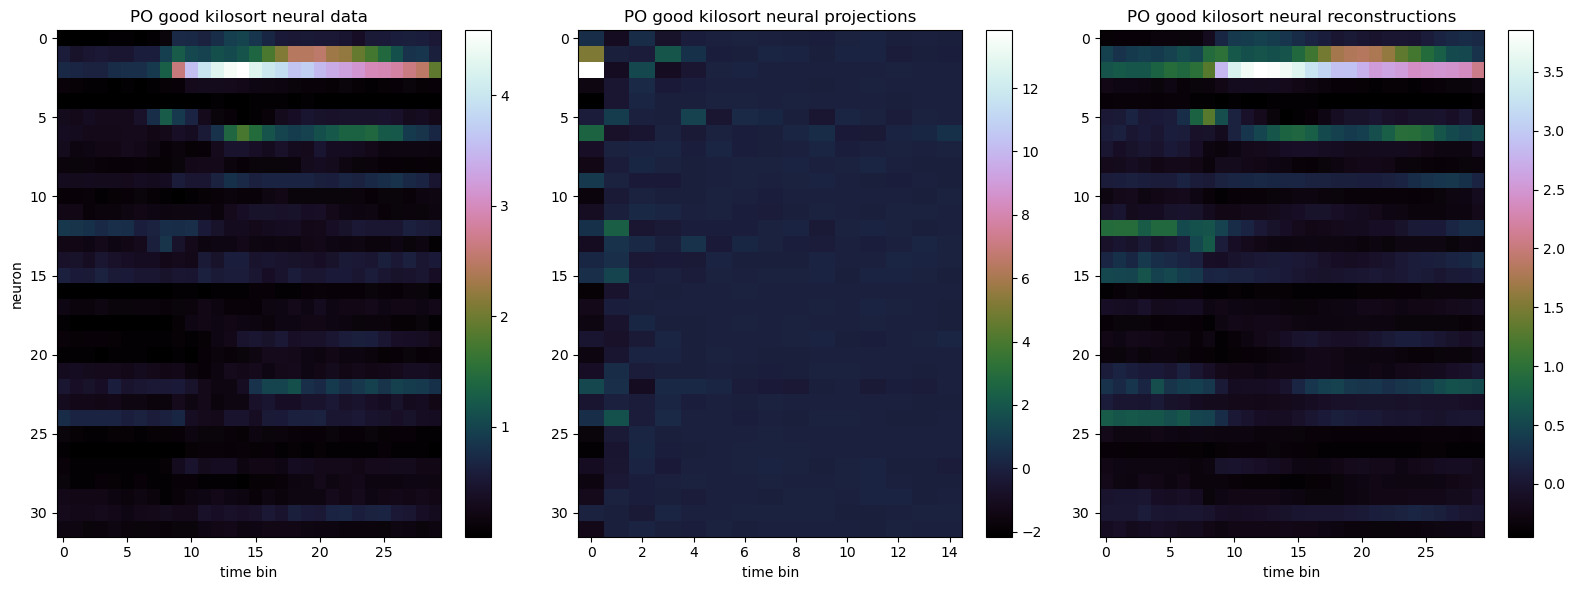

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(16,6))

p1 = axes[0].imshow(regional_good_neural_data.mean(0), aspect='auto', cmap='cubehelix')
axes[0].set_title(roi + ' good kilosort neural data')
axes[0].set_xlabel('time bin')
axes[0].set_ylabel('neuron')
plt.colorbar(p1, ax=axes[0]);

p2 = axes[1].imshow(regional_good_tpca_proj.mean(0), aspect='auto', cmap='cubehelix')
axes[1].set_title(roi + ' good kilosort neural projections')
axes[1].set_xlabel('time bin')
plt.colorbar(p2, ax=axes[1]);

p3 = axes[2].imshow(regional_good_tpca_recon.mean(0), aspect='auto', cmap='cubehelix')
axes[2].set_title(roi + ' good kilosort neural reconstructions')
axes[2].set_xlabel('time bin')
plt.colorbar(p3, ax=axes[2]);

plt.tight_layout()
plt.show()

In [14]:
cv_accs, cv_aucs, cv_ids, cv_obs, cv_preds, cv_probs = decode_static.cv_decode_static(regional_good_neural_data, choices, behave_type='choice', n_folds=5, seed=seed, shuffle=True)

choice fold 1 test accuracy: 0.897 auc: 0.904
choice fold 2 test accuracy: 0.807 auc: 0.886
choice fold 3 test accuracy: 0.842 auc: 0.908
choice fold 4 test accuracy: 0.930 auc: 0.960
choice fold 5 test accuracy: 0.877 auc: 0.853
choice mean of 5-fold cv accuracy: 0.871 auc: 0.902
choice sd of 5-fold cv accuracy: 0.043 auc: 0.035


In [15]:
cv_accs, cv_aucs, cv_ids, cv_obs, cv_preds, cv_probs = decode_static.cv_decode_static(regional_good_neural_data, one_hot_stimuli, behave_type='stimulus', n_folds=5, seed=seed, shuffle=True)

stimulus fold 1 test accuracy: 0.293 auc: 0.821
stimulus fold 2 test accuracy: 0.316 auc: 0.756
stimulus fold 3 test accuracy: 0.333 auc: 0.792
stimulus fold 4 test accuracy: 0.298 auc: 0.779
stimulus fold 5 test accuracy: 0.333 auc: 0.705
stimulus mean of 5-fold cv accuracy: 0.315 auc: 0.770
stimulus sd of 5-fold cv accuracy: 0.017 auc: 0.039
